# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d200/7037ec05b97576da1bd9db5e3ea6a322a577bc833b0dc772238248ef.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Toronto, Ontario, Canada**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(200,'7037ec05b97576da1bd9db5e3ea6a322a577bc833b0dc772238248ef')

# Data Processing

In [2]:
import pandas as pd

# read csv
weather_df = pd.read_csv('data/C2A2_data/BinnedCsvs_d200/7037ec05b97576da1bd9db5e3ea6a322a577bc833b0dc772238248ef.csv')
weather_df.to_csv('Assignment2_raw_CentralOntarioWeather.csv')

# process weather data - drop id, sort by date
weather_df = weather_df.drop(['ID'], axis=1).sort_values(by='Date')#.set_index('Date')
# compute lowest daily tempareture across the region
minTemp_df = weather_df[weather_df['Element']=='TMIN'].drop(['Element'], axis=1)
minTemp_df = minTemp_df.groupby('Date').agg({"Data_Value":[min]})
minTemp_df.columns = ['TMIN']
# compute highest daily tempareture across the region
maxTemp_df = weather_df[weather_df['Element']=='TMAX'].drop(['Element'], axis=1)
maxTemp_df = maxTemp_df.groupby('Date').agg({"Data_Value":[max]})
maxTemp_df.columns = ['TMAX']

# temperature df by date
temperature_df = pd.concat([minTemp_df,maxTemp_df], axis=1, join='inner').reset_index()

#import datetime
# convert string to timestamp
temperature_df['Date'] = pd.to_datetime(temperature_df['Date'])#.dt.date #, format='%d%b%Y:%H:%M:%S.%f')
type(temperature_df['Date'].iloc[0])
temperature_df['Year'] = temperature_df['Date'].dt.strftime('%Y').map(int)
temperature_df['MonthDay'] = temperature_df['Date'].dt.strftime('%m-%d')
temperature_df['DayOfYear'] = temperature_df['Date'].dt.strftime('%j').map(int)

# remove leap day: delete month day of 02-29
temperature_df = temperature_df[(temperature_df['MonthDay']!='02-29')]

# save processed data to csv
temperature_df.to_csv('Assignment2_all_temp.csv', index=False)

In [3]:
# slice dataframes
temperature_2005_2014_df = temperature_df[temperature_df['Year']<2015]
temperature_2015_df = temperature_df[temperature_df['Year']==2015]

# 1. get temperature by day dataframe for average temperatures from 2005 to 2014
temperatureByDay_df = temperature_2005_2014_df.groupby('MonthDay').agg({"TMIN":[min], "TMAX":[max]}).reset_index()
# temperatureByDay_df.columns = ['MonthDay', 'TMIN', 'TMAX']
temperatureByDay_df.columns = temperatureByDay_df.columns.droplevel(1)
temperatureByDay_df['DayOfYear'] = temperatureByDay_df.index + 1

temperatureByDay_df.to_csv('Assignment2_proc_avgTemp.csv', index=False)

In [4]:
# 2. get record breaking temperature
#type(temperatureByDay_index_df.loc[1].loc['TMIN'])
#type(temperature_2015_df.iloc[0].loc['TMIN'])
temperatureByDay_index_df = temperatureByDay_df.set_index('DayOfYear')
temperature_2015_df['TMINRecord'] = temperature_2015_df.apply((lambda row: (row.loc['TMIN'] < temperatureByDay_index_df.loc[row['DayOfYear']].loc['TMIN'])), axis=1)
temperature_2015_df['TMAXRecord'] = temperature_2015_df.apply((lambda row: (row.loc['TMAX'] > temperatureByDay_index_df.loc[row['DayOfYear']].loc['TMAX'])), axis=1)
print("Low record broken: " + str(sum(temperature_2015_df['TMINRecord'])))
print("High record broken: " + str(sum(temperature_2015_df['TMAXRecord'])))

# save processed data to csv
temperature_2015_df.to_csv('Assignment2_proc_recordTemp2015.csv', index=False)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Low record broken: 33
High record broken: 42


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Load Processed Data

In [5]:
import pandas as pd

temperatureByDay_df = pd.read_csv('Assignment2_proc_avgTemp.csv')
temperatureByDay_df

MonthDay  TMIN  TMAX  DayOfYear
0      01-01  -250   134          1
1      01-02  -245   139          2
2      01-03  -270   161          3
3      01-04  -222   133          4
4      01-05  -200   150          5
5      01-06  -260   160          6
6      01-07  -270   178          7
7      01-08  -260   194          8
8      01-09  -236   183          9
9      01-10  -229   110         10
10     01-11  -200   150         11
11     01-12  -176   161         12
12     01-13  -217   206         13
13     01-14  -290   200         14
14     01-15  -290    89         15
15     01-16  -260   103         16
16     01-17  -270   128         17
17     01-18  -275   128         18
18     01-19  -228   117         19
19     01-20  -250   136         20
20     01-21  -320   139         21
21     01-22  -306   117         22
22     01-23  -280   106         23
23     01-24  -295   106         24
24     01-25  -272   106         25
25     01-26  -260    89         26
26     01-27  -311    83         27
27     01-28  -300   125         28
28     01-29  -260   170         29
29     01-30  -255   189         30
..       ...   ...   ...        ...
335    12-02  -135   140        336
336    12-03  -114   170        337
337    12-04  -130   191        338
338    12-05  -159   194        339
339    12-06  -180   167        340
340    12-07  -213    90        341
341    12-08  -214    94        342
342    12-09  -210   110        343
343    12-10  -185   122        344
344    12-11  -175   111        345
345    12-12  -220   156        346
346    12-13  -220   128        347
347    12-14  -206   144        348
348    12-15  -189   150        349
349    12-16  -230   144        350
350    12-17  -245   150        351
351    12-18  -167   128        352
352    12-19  -159    83        353
353    12-20  -230   100        354
354    12-21  -190   144        355
355    12-22  -180   167        356
356    12-23  -170   156        357
357    12-24  -230   150        358
358    12-25  -224   144        359
359    12-26  -194   110        360
360    12-27  -200   178        361
361    12-28  -160   178        362
362    12-29  -180   172        363
363    12-30  -170   100        364
364    12-31  -170   133        365

[365 rows x 4 columns]

In [20]:
import pandas as pd

temperature_2015_df = pd.read_csv('Assignment2_proc_recordTemp2015.csv')

In [18]:
temperature_2015_lowRecords = temperature_2015_df[temperature_2015_df['TMINRecord']]#['TMIN']
temperature_2015_lowRecords

Date  TMIN  TMAX  Year MonthDay  DayOfYear TMINRecord TMAXRecord
11   2015-01-12  -250     6  2015    01-12         12       True      False
12   2015-01-13  -260     0  2015    01-13         13       True      False
43   2015-02-13  -305   -22  2015    02-13         44       True      False
44   2015-02-14  -275   -39  2015    02-14         45       True      False
45   2015-02-15  -340   -44  2015    02-15         46       True      False
46   2015-02-16  -341  -100  2015    02-16         47       True      False
47   2015-02-17  -330   -65  2015    02-17         48       True      False
49   2015-02-19  -277   -67  2015    02-19         50       True      False
50   2015-02-20  -330   -60  2015    02-20         51       True      False
51   2015-02-21  -278   -22  2015    02-21         52       True      False
52   2015-02-22  -270   -25  2015    02-22         53       True      False
53   2015-02-23  -266   -22  2015    02-23         54       True      False
54   2015-02-24  -261   -43  2015    02-24         55       True      False
55   2015-02-25  -250   -42  2015    02-25         56       True      False
56   2015-02-26  -270   -56  2015    02-26         57       True      False
57   2015-02-27  -283   -61  2015    02-27         58       True      False
80   2015-03-22  -150    69  2015    03-22         81       True      False
81   2015-03-23  -170    45  2015    03-23         82       True      False
87   2015-03-29  -133    70  2015    03-29         88       True      False
89   2015-03-31  -110   100  2015    03-31         90       True      False
93   2015-04-04  -100   150  2015    04-04         94       True      False
113  2015-04-24   -95    90  2015    04-24        114       True      False
114  2015-04-25   -70   120  2015    04-25        115       True      False
115  2015-04-26   -55   150  2015    04-26        116       True      False
141  2015-05-22   -30   275  2015    05-22        142       True      False
142  2015-05-23   -40   260  2015    05-23        143       True      False
143  2015-05-24   -11   300  2015    05-24        144       True      False
157  2015-06-07    15   289  2015    06-07        158       True      False
183  2015-07-03    43   261  2015    07-03        184       True      False
184  2015-07-04    60   265  2015    07-04        185       True      False
203  2015-07-23    65   280  2015    07-23        204       True      False
219  2015-08-08    70   270  2015    08-08        220       True      False
297  2015-10-25   -30   167  2015    10-25        298       True      False

In [19]:
temperature_2015_highRecords = temperature_2015_df[temperature_2015_df['TMAXRecord']]#['TMIN']
temperature_2015_highRecords

Date  TMIN  TMAX  Year MonthDay  DayOfYear TMINRecord TMAXRecord
3    2015-01-04  -140   144  2015    01-04          4      False       True
102  2015-04-13   -15   283  2015    04-13        103      False       True
103  2015-04-14   -30   278  2015    04-14        104      False       True
124  2015-05-05    10   283  2015    05-05        125      False       True
126  2015-05-07    56   310  2015    05-07        127      False       True
127  2015-05-08    67   322  2015    05-08        128      False       True
128  2015-05-09    59   326  2015    05-09        129      False       True
129  2015-05-10    56   328  2015    05-10        130      False       True
130  2015-05-11    62   317  2015    05-11        131      False       True
136  2015-05-17    85   294  2015    05-17        137      False       True
137  2015-05-18    79   300  2015    05-18        138      False       True
208  2015-07-28   125   335  2015    07-28        209      False       True
209  2015-07-29   136   344  2015    07-29        210      False       True
210  2015-07-30   120   339  2015    07-30        211      False       True
230  2015-08-19   160   328  2015    08-19        231      False       True
231  2015-08-20   144   328  2015    08-20        232      False       True
250  2015-09-08   162   344  2015    09-08        251      False       True
251  2015-09-09    60   350  2015    09-09        252      False       True
258  2015-09-16    74   299  2015    09-16        259      False       True
259  2015-09-17    89   296  2015    09-17        260      False       True
305  2015-11-02   -10   210  2015    11-02        306      False       True
306  2015-11-03    10   239  2015    11-03        307      False       True
307  2015-11-04     5   239  2015    11-04        308      False       True
308  2015-11-05    30   250  2015    11-05        309      False       True
309  2015-11-06    15   244  2015    11-06        310      False       True
313  2015-11-10   -40   215  2015    11-10        314      False       True
321  2015-11-18     0   183  2015    11-18        322      False       True
322  2015-11-19   -40   194  2015    11-19        323      False       True
323  2015-11-20   -31   189  2015    11-20        324      False       True
340  2015-12-07   -55   100  2015    12-07        341      False       True
341  2015-12-08   -71   120  2015    12-08        342      False       True
342  2015-12-09   -30   144  2015    12-09        343      False       True
343  2015-12-10   -20   150  2015    12-10        344      False       True
344  2015-12-11   -30   156  2015    12-11        345      False       True
345  2015-12-12   -25   161  2015    12-12        346      False       True
346  2015-12-13   -20   200  2015    12-13        347      False       True
347  2015-12-14    35   222  2015    12-14        348      False       True
348  2015-12-15   -13   222  2015    12-15        349      False       True
356  2015-12-23    10   183  2015    12-23        357      False       True
357  2015-12-24   -10   189  2015    12-24        358      False       True
358  2015-12-25   -75   172  2015    12-25        359      False       True
359  2015-12-26   -60   122  2015    12-26        360      False       True

# Plot Functions for time series data

In [5]:
# don't forget the python magic for interactive matplotlib environment

%matplotlib notebook

import matplotlib as mpl
import matplotlib.pyplot as plt

## Simple line plot

In [6]:
def simpleLinePlot(data, y, X, title='Example Plot', ylabel='y', xlabel='x', lineTyp='-'):
    
    """Construct a simple line plot with provided data, 
    series definition, and labels.
    data: dataframe object
    y: name of the y
    X: names of x series
    ylabel: label of y
    xlabel: label of x
    lineTyp: the line type look
    """
    
    import matplotlib.pyplot as plt
    import numpy as np
    
    plt.figure()
    
    # plot data
    for x in X:
        plt.plot(data[y], data[x], lineTyp)    

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel);
    
    plt.gca().fill_between(range(len(linear_data)), 
                       linear_data, exponential_data, 
                       facecolor='blue', 
                       alpha=0.25)
    
    # add a legend with legend entries (because we didn't have labels when we plotted the data series)
    plt.legend(['Baseline', 'Competition', 'Us'])

    plt.show()
    

<IPython.core.display.Javascript object>


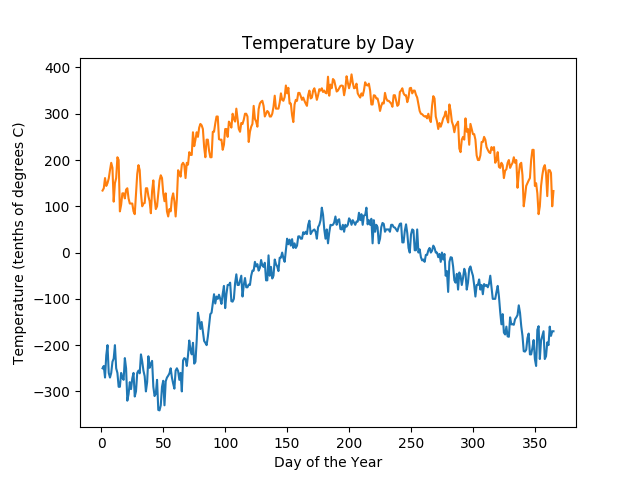

In [7]:
title = 'Temperature by Day'
y = 'DayOfYear'
series = ['TMIN', 'TMAX']
ylabel = 'Temperature (tenths of degrees C)'
xlabel = 'Day of the Year'
simpleLinePlot(temperatureByDay_df,y=y,X=series,title=title,ylabel=ylabel,xlabel=xlabel)

In [13]:
simpleLinePlot?

## Clean line plot
based on minimum chart junk principle

In [ ]:
def cleanLinePlot(data, y, X, title='Example Plot', ylabel='y', xlabel='x', lineTyp='-'):
    
    """Construct a simple line plot with provided data, 
    series definition, and labels.
    data: dataframe object
    y: name of the y
    X: names of x series
    ylabel: label of y
    xlabel: label of x
    lineTyp: the line type look
    """
    
    import matplotlib.pyplot as plt
    import numpy as np
    
    plt.figure()
    
    # plot data
    for x in X:
        plt.plot(data[y], data[x], lineTyp)    

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel);
    
    plt.show()
    